In [60]:
import pandas as pd

raw_data = pd.read_csv("LP_PDBBind.csv")

In [61]:

print(raw_data.shape)
raw_data.head()

(19443, 16)


,Unnamed: 0,header,smiles,category,seq,resolution,date,type,new_split,CL1,CL2,CL3,remove_for_balancing_val,kd/ki,value,covalent
0,6r8o,isomerase,CSc1ccccc1[C@H]1CCCN1C(=O)CNC(=O)NCc1ccc2c(c1)...,refined,GNPLVYLDVDANGKPLGRVVLELKADVVPKTAENFRALCTGEKGFG...,1.36,2019-11-27,isomerase,test,True,True,True,False,Kd=0.006uM,8.22,False
1,3fh7,hydrolase/hydrolase inhibitor,O=C([O-])CCC[N@H+]1CCC[C@H]1COc1ccc(Oc2ccc(Cl)...,refined,VDTCSLASPASVCRTKHLHLRCSVDFTRRTLTGTAALTVQSQEDNL...,2.05,2010-01-05,hydrolase,test,True,True,True,False,Kd=25nM,7.60,False
2,4b7r,hydrolase,CCC(CC)O[C@@H]1C[C@H](C(=O)[O-])C[C@H]([NH3+])...,refined,VKLAGNSSLCPVSGWAIYSKDNSVRIGSKGDVFVIREPFISCSPLE...,1.90,2012-10-03,hydrolase,NaN,True,True,True,False,Ki=0.23nM,9.64,False
3,3qfd,immune system,CC[C@H](C)[C@H](NC(=O)CNC(=O)[C@H](C)NC(=O)[C@...,refined,GSHSMRYFFTSVSRPGRGEPRFIAVGYVDDTQFVRFDSDAASQRME...,1.68,2011-09-28,other,train,False,False,False,False,Kd=68uM,4.17,False
4,3fvn,membrane protein,[NH3+][C@@H](C[C@]1(C(=O)[O-])C[C@H]2OCC[C@@H]...,refined,ANRTLIVTTILEEPYVMYRKSDKPLYGNDRFEGYCLDLLKELSNIL...,1.50,2010-01-19,membrane,val,True,True,True,False,Ki=169nM,6.77,False


In [62]:
import collections
print(collections.Counter(raw_data.header))
print(collections.Counter(raw_data.category))
print(collections.Counter(raw_data.type))

Counter({'hydrolase': 3326, 'transferase': 3035, 'hydrolase/hydrolase inhibitor': 2046, 'transferase/transferase inhibitor': 1851, 'transcription': 672, 'lyase': 635, 'immune system': 459, 'signaling protein': 443, 'transport protein': 436, 'oxidoreductase': 412, 'ligase': 270, 'membrane protein': 229, 'isomerase': 218, 'chaperone': 217, 'sugar binding protein': 214, 'protein binding': 205, 'lyase/lyase inhibitor': 193, 'viral protein': 167, 'cell cycle': 150, 'ligase/ligase inhibitor': 148, 'transferase/inhibitor': 129, 'dna binding protein': 116, 'hydrolase/inhibitor': 104, 'peptide binding protein': 97, 'apoptosis': 95, 'oxidoreductase/oxidoreductase inhibitor': 93, 'transcription/transcription inhibitor': 83, 'protein binding/inhibitor': 83, 'gene regulation': 83, 'isomerase/isomerase inhibitor': 82, 'lipid binding protein': 76, 'protein transport': 73, 'transcription/inhibitor': 69, 'metal binding protein': 68, 'cell adhesion': 65, 'structural protein': 62, 'hormone receptor': 46,

Start : Use the headers as categories (group all the small categories)
Ask if there are libraries that do protein fingerprints
Then try to caracterise the amino acid chain in order to use it as an input
Then maybe explore the alphafold API in order to do the same thing


In [71]:
# Improved preprocessing: handle Kd encoding and hydrolase header, including ~ and =
import re

def standardize_kd(value, unit):
    '''Convert Kd values to float in nM.'''
    try:
        val = float(value)
    except:
        return None
    unit = unit.lower().strip()
    if unit in ['nm', 'nanomolar', 'nanomolars']:
        return val
    elif unit in ['um', 'micromolar', 'micromolars']:
        return val * 1000
    elif unit in ['mm', 'millimolar', 'millimolars']:
        return val * 1_000_000
    elif unit in ['pm', 'picomolar', 'picomolars']:
        return val / 1000
    else:
        return None

# Only keep rows where header contains 'hydrolase' (not exact match) and type contains 'Kd' in 'kd/ki' column
hydrolase_mask = raw_data['header'].str.contains('hydrolase', case=False, na=False)
kd_mask = raw_data['kd/ki'].str.contains('Kd', case=False, na=False)
subset = raw_data[hydrolase_mask & kd_mask].copy()

# Extract Kd value and unit from 'kd/ki' column (e.g., 'Kd=0.006uM' or 'Kd~500uM')
def extract_kd(row):
    s = str(row['kd/ki'])
    match = re.match(r'Kd\s*[=~]\s*([\d\.]+)\s*([a-zA-Z]+)', s)
    if match:
        val, unit = match.groups()
        return standardize_kd(val, unit)
    return None

subset['Kd_nM'] = subset.apply(extract_kd, axis=1)

# Print rows that were dropped due to failed Kd extraction or missing smiles
dropped = subset[(subset['Kd_nM'].isna()) | (subset['smiles'].isna())]
print(f"Dropped rows: {dropped.shape[0]} in the subset")
print(dropped[['kd/ki', 'smiles']].head(20))

# Print corresponding rows in raw_data for missing smiles
missing_smiles_idx = dropped[dropped['smiles'].isna()].index
print(f"Corresponding rows: {dropped.shape[0]} in the raw data")
print(raw_data.loc[missing_smiles_idx][['kd/ki', 'smiles']].head(20))

# Drop rows with missing or non-standardized Kd and smiles
subset = subset.dropna(subset=['Kd_nM', 'smiles'])

# Final subset: only smiles and standardized Kd
final_subset = subset[['smiles', 'Kd_nM']].copy()
# Count rows where header contains 'hydrolase' and kd/ki contains 'Kd'
print((hydrolase_mask & kd_mask).sum())

print(final_subset.shape)
final_subset.head()

Dropped rows: 65 in the subset
           kd/ki smiles
168    Kd=90.1uM    NaN
832    Kd=32.1nM    NaN
895   Kd=11.63uM    NaN
1350  Kd=104.2nM    NaN
1453   Kd=0.46uM    NaN
1537    Kd=191nM    NaN
1573    Kd=5.4uM    NaN
1635  Kd=0.061uM    NaN
1733   Kd=0.11uM    NaN
1807   Kd=0.12uM    NaN
1850    Kd=1.0uM    NaN
2135    Kd=8.0uM    NaN
2438   Kd=5.77uM    NaN
3582   Kd=12.9uM    NaN
3591     Kd=13uM    NaN
4189   Kd=0.74uM    NaN
4354   Kd=83.9nM    NaN
4837     Kd=68nM    NaN
5031   Kd=19.6uM    NaN
5525  Kd=0.663uM    NaN
Corresponding rows: 65 in the raw data
           kd/ki smiles
168    Kd=90.1uM    NaN
832    Kd=32.1nM    NaN
895   Kd=11.63uM    NaN
1350  Kd=104.2nM    NaN
1453   Kd=0.46uM    NaN
1537    Kd=191nM    NaN
1573    Kd=5.4uM    NaN
1635  Kd=0.061uM    NaN
1733   Kd=0.11uM    NaN
1807   Kd=0.12uM    NaN
1850    Kd=1.0uM    NaN
2135    Kd=8.0uM    NaN
2438   Kd=5.77uM    NaN
3582   Kd=12.9uM    NaN
3591     Kd=13uM    NaN
4189   Kd=0.74uM    NaN
4354   Kd=83.9nM  

,smiles,Kd_nM
1,O=C([O-])CCC[N@H+]1CCC[C@H]1COc1ccc(Oc2ccc(Cl)...,25.0
22,Nc1nc(N2CC[NH+](CCOc3ccc(Br)cc3)CC2)n[nH]1,1690.0
30,NC(=[NH2+])c1ccc(CNC(=O)[C@@H]2CCCN2C(=O)CCC2C...,562.0
33,CC(=O)N[C@H]1[C@H](O[C@@H]2[C@@H](CO)O[C@@H](O...,14200.0
37,C[C@H]1CCC[C@H](O)CCC/C=C/c2cc(O)cc(O)c2C(=O)O1,440.0


During the preprocessing it appeared that some of the data points were missing the smiles. 

Now that we have a propper subset of preprocessed data, we will train several regression models (Graph Neural Network and Random Forest Regression) and optimize their hyperparameters in order to optimize the prediction of the Kd values. The models will all be trained with the same fingerprints extracted from the SMILES.

Random Forest Optimization

In [75]:
!pip install matplotlib

     ---------------------------------------- 0.0/114.6 kB ? eta -:--:--
     ---------- ---------------------------- 30.7/114.6 kB 1.4 MB/s eta 0:00:01
     ----------------------- ------------- 71.7/114.6 kB 660.6 kB/s eta 0:00:01
     ------------------------------------ 114.6/114.6 kB 745.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
    --------------------------------------- 0.1/8.1 MB 3.3 MB/s eta 0:00:03
    --------------------------------------- 0.2/8.1 MB 2.1 MB/s eta 0:00:04
   - -------------------------------------- 0.2/8.1 MB 1.8 MB/s eta 0:00:05
   -- ------------------------------------- 0.4/8.1 MB 2.4 MB/s eta 0:00:04
   -- ------------------------------------- 0.5/8.1 MB 2.3 MB/s eta 0:00:04
   --- ------------------------------------ 0.7/8.1 MB 2.6 MB/s eta 0:00:03
   --- ------------------------------------ 0.7/8.1 MB 2.4 MB/s eta 0:00:04
   --- ------------------------------------ 0.8/8.1 MB 2.2 MB/s eta 0:00:04
   ----- -


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: C:\Users\33695\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
# Fingerprint extraction and Random Forest Regression with hyperparameter optimization and standardized data
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import pandas as pd

r_fingerprint=2
Bits_fingerprint=2048

# Extract Morgan fingerprints from SMILES
def smiles_to_fingerprint(smiles, radius=r_fingerprint, nBits=Bits_fingerprint):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return np.zeros(nBits)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)
    return np.array(fp)

X = np.array([smiles_to_fingerprint(s) for s in final_subset['smiles']])
y = final_subset['Kd_nM'].values

# Standardize features and target
scaler_X = StandardScaler()
scaler_y = StandardScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).ravel()

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [10, 50, 100, 200],
    'max_depth': np.linspace(1, 100, 10).astype(int),
    'min_samples_split': [1, 2, 5, 10]
}

rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1, return_train_score=True)
grid_search.fit(X_train, y_train)

# Best model and predictions
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Metrics
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE (standardized): {mse:.2f}")
print(f"Test R2 (standardized): {r2:.2f}")

# Prepare matrix for heatmap plots
results = grid_search.cv_results_
df_results = pd.DataFrame(results)
df_results['max_depth'] = df_results['param_max_depth'].fillna(-1).astype(int)
df_results['n_estimators'] = df_results['param_n_estimators'].astype(int)

# Choose a fixed value for min_samples_split, e.g. 2
fixed_split = 2
filtered = df_results[df_results['param_min_samples_split'] == fixed_split]

# Calculate MSE and R2 for each parameter combination
mse_matrix = filtered.pivot(index='max_depth', columns='n_estimators', values='mean_test_score')
r2_matrix = filtered.pivot(index='max_depth', columns='n_estimators', values='mean_train_score')

# Plot MSE heatmap (note: mean_test_score is negative MSE, so invert sign)
plt.figure(figsize=(8,6))
plt.title('Random Forest Hyperparameter Grid - MSE (CV, standardized)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
im = plt.imshow(-mse_matrix.values, cmap='viridis', aspect='auto', origin='lower')
plt.xticks(np.arange(len(mse_matrix.columns)), mse_matrix.columns)
plt.yticks(np.arange(len(mse_matrix.index)), mse_matrix.index)
plt.colorbar(im, label='MSE')
plt.show()

# Plot R2 heatmap (using train score for illustration, can be replaced with test R2 if calculated)
plt.figure(figsize=(8,6))
plt.title('Random Forest Hyperparameter Grid - R2 (Train, standardized)')
plt.xlabel('n_estimators')
plt.ylabel('max_depth')
im = plt.imshow(r2_matrix.values, cmap='plasma', aspect='auto', origin='lower')
plt.xticks(np.arange(len(r2_matrix.columns)), r2_matrix.columns)
plt.yticks(np.arange(len(r2_matrix.index)), r2_matrix.index)
plt.colorbar(im, label='R2')
plt.show()

[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:33] DEPRECATION WARNING: please use MorganGenerator
[17:37:34] DEPRECATION WARNING: please use MorganGenerator
[17:37:34] DEPRECATION WARNING: please use MorganGenerator
[17:37:34] DEPRECATION WARNING: please use MorganGenerator
[17:37:34] DEPRECATION WARNING: please use MorganGenerat

KeyboardInterrupt: 

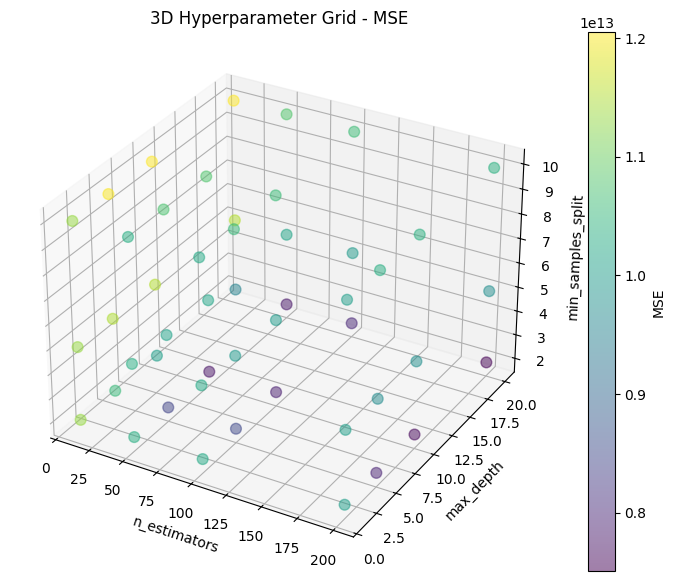

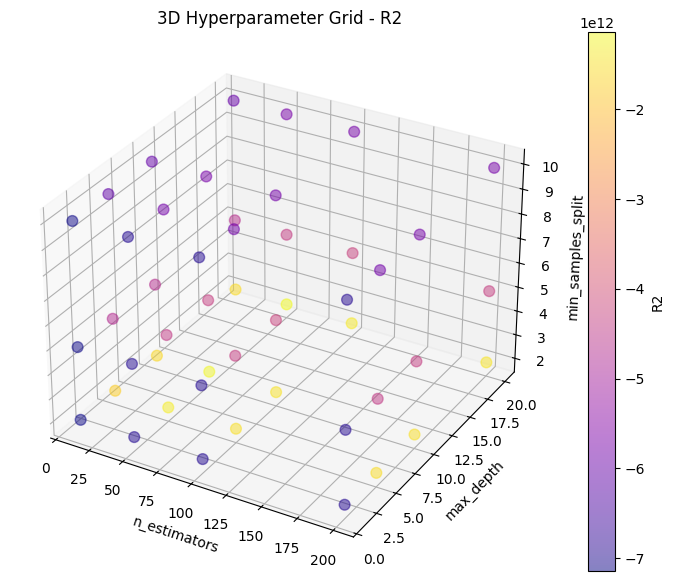

In [79]:
# 3D scatter plot for hyperparameter grid search results (MSE and R2)
from mpl_toolkits.mplot3d import Axes3D

# 3D scatter for MSE
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    df_results['n_estimators'],
    df_results['max_depth'],
    df_results['param_min_samples_split'],
    c=-df_results['mean_test_score'],
    cmap='viridis',
    s=60,
    alpha=0.5
)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('min_samples_split')
plt.title('3D Hyperparameter Grid - MSE')
fig.colorbar(sc, label='MSE')
plt.show()

# 3D scatter for R2
fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(
    df_results['n_estimators'],
    df_results['max_depth'],
    df_results['param_min_samples_split'],
    c=df_results['mean_train_score'],
    cmap='plasma',
    s=60,
    alpha=0.5
)
ax.set_xlabel('n_estimators')
ax.set_ylabel('max_depth')
ax.set_zlabel('min_samples_split')
plt.title('3D Hyperparameter Grid - R2')
fig.colorbar(sc, label='R2')
plt.show()